In [390]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import pandas as pd
from scipy.stats import norm


# NEW: we will use ks_2samp for a simple statistical test on Kd distributions
from scipy.stats import ks_2samp

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [391]:
## some scale factors and constant you might use

## mass square of muon: m_muon^2 (in GeV)
sqm1 = (0.105658) * (0.105658)
## mass square of electron: m_e^2 (in GeV)
sqme = (0.0005109989) * (0.0005109989)
## mass of Z boson (in GeV)
mZ = 91.1876


## constants for the scale factor of MC. The MC is produced at a certain cross section\
## with certain number of events. To increase statistics, the event numbers generated are usually very large,\
## therefore a scale factor is needed to apply on the MC to make them agree with data.
## Scale factor for each MC component is: lumi * xsec / nevt, as provided below

## Luminosity of each year
lumi12 = 11580.
lumi11 = 2330.

## MC cross section of each process
xsecZZ412 = 0.107
xsecZZ2mu2e12 = 0.249
xsecZZ411 = 0.093
xsecZZ2mu2e11 = 0.208

xsecTTBar12 = 200.
xsecTTBar11 = 19.504

xsecDY5012 = 2955.
xsecDY1012 = 10.742
xsecDY5011 = 2475.
xsecDY1011 = 9507.
  
scalexsecHZZ12 = 0.0065
scalexsecHZZ11 = 0.0057

## Number of MC Events generated for each process
nevtZZ4mu12 = 1499064
nevtZZ4e12 = 1499093
nevtZZ2mu2e12 = 1497445
nevtHZZ12 = 299973 
nevtTTBar12 = 6423106
nevtDY5012 = 29426492
nevtDY1012 = 6462290
  
nevtZZ4mu11 = 1447136
nevtZZ4e11 = 1493308
nevtZZ2mu2e11 = 1479879
nevtHZZ11 = 299683
nevtTTBar11 = 9771205
nevtDY5011 = 36408225
nevtDY1011 = 39909640


labels = ['$m_{H}$ = 125 GeV', r'ZZ $\rightarrow$ 4l', 'Z/$\gamma^{*}$ + X', r'$t\bar{t}$']
colors = ['r','b','g','gray']
scales_higgs = [lumi11*scalexsecHZZ11/nevtHZZ11, lumi12*scalexsecHZZ12/nevtHZZ12]
scales_zz = [lumi11*xsecZZ411/nevtZZ4mu11, lumi11*xsecZZ2mu2e11/nevtZZ2mu2e11, lumi11*xsecZZ411/nevtZZ4e11,\
             lumi12*xsecZZ412/nevtZZ4mu12, lumi12*xsecZZ2mu2e12/nevtZZ2mu2e12, lumi12*xsecZZ412/nevtZZ4e12]
scales_dy = [lumi11*xsecDY1011/nevtDY1011, lumi11*xsecDY5011/nevtDY5011, \
             lumi12*xsecDY1012/nevtDY1012, lumi11*xsecDY5012/nevtDY5012]
scales_tt = [lumi11*xsecTTBar11/nevtTTBar11, lumi12*xsecTTBar12/nevtTTBar12]

In [392]:
### open the files ###
# read datalist of each year and combine to one 
data_year  = [pd.read_csv('data/clean_data_2011.csv',index_col=None, header=0)]
data_year += [pd.read_csv('data/clean_data_2012.csv',index_col=None, header=0)]
data = pd.concat(data_year,axis=0,ignore_index=True)


# read MClist of each process and each year
mc_higgs_11 = pd.read_csv('MC/higgs2011.csv',index_col=None, header=0)
mc_higgs_12 = pd.read_csv('MC/higgs2012.csv',index_col=None, header=0)
## ZZ*
mc_zz4mu_11 = pd.read_csv('MC/zzto4mu2011.csv',index_col=None, header=0)
mc_zz2mu2e_11 = pd.read_csv('MC/zzto2mu2e2011.csv',index_col=None, header=0)
mc_zz4e_11 = pd.read_csv('MC/zzto4e2011.csv',index_col=None, header=0)

mc_zz4mu_12 = pd.read_csv('MC/zzto4mu2012.csv',index_col=None, header=0)
mc_zz2mu2e_12 = pd.read_csv('MC/zzto2mu2e2012.csv',index_col=None, header=0)
mc_zz4e_12 = pd.read_csv('MC/zzto4e2012.csv',index_col=None, header=0)
## Drell-Yan
mc_dy10_11 = pd.read_csv('MC/dy1050_2011.csv',index_col=None, header=0)
mc_dy50_11 = pd.read_csv('MC/dy50_2011.csv',index_col=None, header=0)
mc_dy10_12 = pd.read_csv('MC/dy1050_2012.csv',index_col=None, header=0)
mc_dy50_12 = pd.read_csv('MC/dy50_2012.csv',index_col=None, header=0)
## ttbar
mc_ttbar_11 = pd.read_csv('MC/ttbar2011.csv',index_col=None, header=0)
mc_ttbar_12 = pd.read_csv('MC/ttbar2012.csv',index_col=None, header=0)


# creat a combined list of MC to study the shape
mc_higgs = [mc_higgs_11, mc_higgs_12]
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
mc_dy = [mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12]
mc_tt = [mc_ttbar_11, mc_ttbar_12]

mc_sig = pd.concat(mc_higgs,axis=0,ignore_index=True)
mc_bkg_zz = pd.concat(mc_zz,axis=0,ignore_index=True)
mc_bkg_dy = pd.concat(mc_dy,axis=0,ignore_index=True)
mc_bkg_tt = pd.concat(mc_tt,axis=0,ignore_index=True)

## For Selections:
mc_all = [mc_higgs, mc_zz, mc_dy, mc_tt]

In [393]:
#This is the header of the csv file:
#Run,Event,PID1,Q1,E1,px1,py1,pz1,eta1,phi1,PID2,Q2,E2,px2,py2,pz2,eta2,phi2,PID3,Q3,E3,px3,py3,pz3,eta3,phi3,PID4,Q4,E4,px4,py4,pz4,eta4,phi4
def ReadEntries(lis):
    return lis['PID1'],lis['Q1'],lis['E1'],lis['px1'],lis['py1'],lis['pz1'],lis['eta1'],lis['phi1'], \
    lis['PID2'],lis['Q2'],lis['E2'],lis['px2'],lis['py2'],lis['pz2'],lis['eta2'],lis['phi2'], \
    lis['PID3'],lis['Q3'],lis['E3'],lis['px3'],lis['py3'],lis['pz3'],lis['eta3'],lis['phi3'], \
    lis['PID4'],lis['Q4'],lis['E4'],lis['px4'],lis['py4'],lis['pz4'],lis['eta4'],lis['phi4']

def pt(px, py):
    return np.sqrt(px**2 + py**2)

def invMass(E, px, py, pz):
    return np.sqrt(E**2 - (px**2 + py**2 + pz**2))

def InvMass_4l(lists):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = lists['E1'] + lists['E2'] + lists['E3'] + lists['E4']
    px_tot = lists['px1'] + lists['px2'] + lists['px3'] + lists['px4']
    py_tot = lists['py1'] + lists['py2'] + lists['py3'] + lists['py4']
    pz_tot = lists['pz1'] + lists['pz2'] + lists['pz3'] + lists['pz4']
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

In [394]:
def PlotShape(variable, rmin, rmax, nbins):
    for i,var in enumerate(variable):
        hist, bins = np.histogram(var, bins = nbins, range = (rmin,rmax))
        bincenter = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bincenter, hist * (1./len(var)), color = colors[i], label=labels[i])
    plt.legend(fontsize = 10)

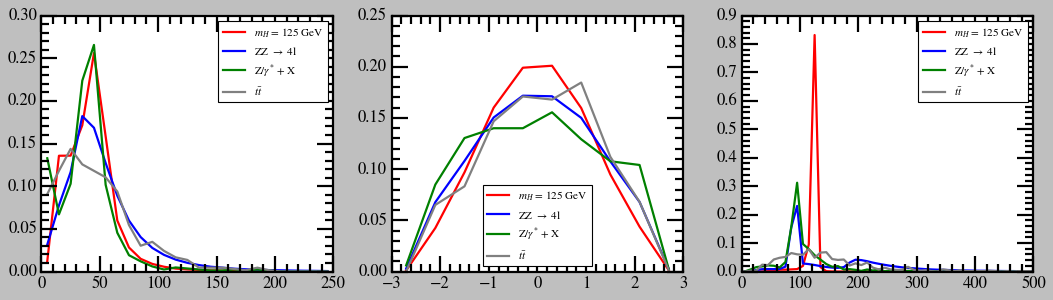

In [395]:
pt1_sig = pt(mc_sig['px1'], mc_sig['py1'])
pt1_bkg_zz = pt(mc_bkg_zz['px1'], mc_bkg_zz['py1'])
pt1_bkg_dy = pt(mc_bkg_dy['px1'], mc_bkg_dy['py1'])
pt1_bkg_tt = pt(mc_bkg_tt['px1'], mc_bkg_tt['py1'])

pt1 = [pt1_sig,pt1_bkg_zz,pt1_bkg_dy,pt1_bkg_tt]
eta1 = [mc_sig['eta1'], mc_bkg_zz['eta1'], mc_bkg_dy['eta1'], mc_bkg_tt['eta1']]
invM4l = [InvMass_4l(mc_sig),InvMass_4l(mc_bkg_zz),InvMass_4l(mc_bkg_dy),InvMass_4l(mc_bkg_tt)]

plt.figure(figsize = (16,4))
plt.subplot(1, 3, 1)
PlotShape(pt1, 0, 250, 25)
plt.subplot(1, 3, 2)
PlotShape(eta1, -3, 3, 10)
plt.subplot(1, 3, 3)
PlotShape(invM4l, 0, 500, 50)

In [396]:
def obj(pid,px,py,eta):  ## object selection for a single object
    pt_obj = pt(px,py)
    if (np.abs(pid) == 13 and pt_obj > 5.) or (np.abs(pid) == 11 and pt_obj > 7.):
        if (np.abs(pid) == 13 and np.abs(eta) < 2.4) or (np.abs(pid) == 11 and np.abs(eta) < 2.5):
            return 1
    #if (np.abs(pid) == 13 and pt_obj > 5. and ...) or (np.abs(pid) == 11 and pt_obj > 7. and ...):
    else:
        return 0
    
    
def objsel(lis):  ## Creat an column to the dataset indicating whether this event passes the object selection
    pass_obj = []
    for row in lis.itertuples():   ## loop over each event(each row)
        pass_obj.append(obj(row.PID1,row.px1,row.py1,row.eta1) and obj(row.PID2,row.px2,row.py2,row.eta2) and obj(row.PID3,row.px3,row.py3,row.eta3) and obj(row.PID4,row.px4,row.py4,row.eta4))
    lis['PassObj'] = pass_obj       

In [397]:
def z_window_twopairs(mass1, mass2, lower1=40, upper1=100, lower2=12, upper2=100):
    '''Z boson mass window for two pairs'''
    # Determine which mass is closer to mZ
    if abs(mass1 - mZ) <= abs(mass2 - mZ):
        z1_mass = mass1
        z2_mass = mass2
    else:
        z1_mass = mass2
        z2_mass = mass1
    
    # Check if both masses are within their respective windows
    if (z1_mass > lower1 and z1_mass < upper1) and (z2_mass > lower2 and z2_mass < upper2):
        return 1
    else:
        return 0

    

    

def evt(PID1,Q1,E1,px1,py1,pz1,PID2,Q2,E2,px2,py2,pz2,PID3,Q3,E3,px3,py3,pz3,PID4,Q4,E4,px4,py4,pz4):

    if(PID1+PID2+PID3+PID4 != 0):    ### charge conservation and lepton flavor conservation
        return 0
    
    #########################################
    ########## More Selections ##############
    #########################################
    
    pt1 = pt(px1,py1)
    pt2 = pt(px2,py2)
    pt3 = pt(px3,py3)
    pt4 = pt(px4,py4)

    if(PID1 != PID2 and PID1 != PID3 and PID1 != PID4): ### 2mu2e event, only one combination
        m_z1 = np.sqrt((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2))
        m_z2 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
        ### More Selections ####
        ### If XXX return 1...##
        return z_window_twopairs(m_z1, m_z2)
        ########################
    else: ### 4mu or 4e event, 3 different combination
        ##c1
        m_z1_c1 = np.sqrt((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2))
        m_z2_c1 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
        ##c2
        m_z1_c2 = np.sqrt((E1+E3)**2 - ((px1+px3)**2 + (py1+py3)**2 + (pz1+pz3)**2))
        m_z2_c2 = np.sqrt((E2+E4)**2 - ((px2+px4)**2 + (py2+py4)**2 + (pz2+pz4)**2))
        ##c3
        m_z1_c3 = np.sqrt((E1+E4)**2 - ((px1+px4)**2 + (py1+py4)**2 + (pz1+pz4)**2))
        m_z2_c3 = np.sqrt((E2+E3)**2 - ((px2+px3)**2 + (py2+py3)**2 + (pz2+pz3)**2))
        ################# More Selections ###########################################
        ### among the 3 combination based on charge and mass to mass of the Z boson##
        #############################################################################
        return z_window_twopairs(m_z1_c1, m_z2_c1) or z_window_twopairs(m_z1_c2, m_z2_c2) or z_window_twopairs(m_z1_c3, m_z2_c3)



        


def evtsel(lis):   ### Similar as the Function: objsel shown above
    pass_evt = []
    for row in lis.itertuples():
        pass_evt.append(evt(row.PID1,row.Q1,row.E1,row.px1,row.py1,row.pz1,\
                            row.PID2,row.Q2,row.E2,row.px2,row.py2,row.pz2,\
                            row.PID3,row.Q3,row.E3,row.px3,row.py3,row.pz3,\
                            row.PID4,row.Q4,row.E4,row.px4,row.py4,row.pz4))
    lis['PassEvt'] = pass_evt

In [398]:
# ---------------------------
# NEW: Example Kd calculation
# ---------------------------
def KdCalc(E1, px1, py1, pz1,
           E2, px2, py2, pz2,
           E3, px3, py3, pz3,
           E4, px4, py4, pz4):
    """
    Placeholder for your actual Kd formula.

    For illustration, we’ll define a *fake* Kd that depends on
    the total pT of the 4l system. Replace with the correct formula
    or matrix-element approach as needed.
    """
    # 4-vector sums
    E_tot = E1 + E2 + E3 + E4
    px_tot = px1 + px2 + px3 + px4
    py_tot = py1 + py2 + py3 + py4
    pz_tot = pz1 + pz2 + pz3 + pz4
    
    # Fake "discriminant" based on total pT or something else
    pT_4l = np.sqrt(px_tot**2 + py_tot**2)
    # You might do a ratio-based or ME-based approach. For example:
    # kd = Dsig / (Dsig + Dbkg), etc.
    kd = pT_4l / (E_tot + 1e-6)  # Just a toy example
    return kd

def addKdColumn(lis):
    kd_vals = []
    for row in lis.itertuples():
        kd = KdCalc(row.E1, row.px1, row.py1, row.pz1,
                    row.E2, row.px2, row.py2, row.pz2,
                    row.E3, row.px3, row.py3, row.pz3,
                    row.E4, row.px4, row.py4, row.pz4)
        kd_vals.append(kd)
    lis["Kd"] = kd_vals

In [399]:
### Apply object selection and event selection to data and each MC process###
print('Original data shape:',data.shape[0])
objsel(data)
evtsel(data)
# print(data)
print('After object selection',data.query('PassObj == 1').shape[0])
data = data.query('PassObj == 1 and PassEvt == 1')
print('After object and event selection',data.shape[0])

# addKdColumn(data)


for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        print('Processing MC:',labels[i], 'Year:', 2011 + j)
        print('Original MC shape:',pro.shape[0])
        objsel(pro)
        evtsel(pro)
        print('After object selection',pro.query('PassObj == 1').shape[0])
        mc_all[i][j] = pro.query('PassObj == 1 and PassEvt == 1')
        print('After object and event selection',mc_all[i][j].shape[0])

        # addKdColumn(mc_all[i][j])

Original data shape: 2724
After object selection 989
After object and event selection 370
Processing MC: $m_{H}$ = 125 GeV Year: 2011
Original MC shape: 52248


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:45: RuntimeWarning: invalid value encountered in sqrt
  m_z2_c1 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:37: RuntimeWarning: invalid value encountered in sqrt
  m_z2 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:50: RuntimeWarning: invalid value encountered in sqrt
  m_z1_c3 = np.sqrt((E1+E4)**2 - ((px1+px4)**2 + (py1+py4)**2 + (pz1+pz4)**2))
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:47: RuntimeWarning: invalid value encountered in sqrt
  m_z1_c2 = np.sqrt((E1+E3)**2 - ((px1+px3)**2 + (py1+py3)**2 + (pz1+pz3)**2))
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:48: RuntimeWarning: invalid value encountered in sqrt
  m_z2_c2 = np.sqrt((E

After object selection 45399
After object and event selection 41989
Processing MC: $m_{H}$ = 125 GeV Year: 2012
Original MC shape: 40530
After object selection 36676
After object and event selection 34111
Processing MC: ZZ $\rightarrow$ 4l Year: 2011
Original MC shape: 209504


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:44: RuntimeWarning: invalid value encountered in sqrt
  m_z1_c1 = np.sqrt((E1+E2)**2 - ((px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2))


After object selection 162855
After object and event selection 128842
Processing MC: ZZ $\rightarrow$ 4l Year: 2012
Original MC shape: 155454
After object selection 112091
After object and event selection 64121
Processing MC: ZZ $\rightarrow$ 4l Year: 2013
Original MC shape: 144999
After object selection 95762
After object and event selection 79363
Processing MC: ZZ $\rightarrow$ 4l Year: 2014
Original MC shape: 183843
After object selection 149413
After object and event selection 119968
Processing MC: ZZ $\rightarrow$ 4l Year: 2015
Original MC shape: 124496
After object selection 98530
After object and event selection 58956
Processing MC: ZZ $\rightarrow$ 4l Year: 2016
Original MC shape: 107496
After object selection 82249
After object and event selection 68794
Processing MC: Z/$\gamma^{*}$ + X Year: 2011
Original MC shape: 59
After object selection 1
After object and event selection 0
Processing MC: Z/$\gamma^{*}$ + X Year: 2012
Original MC shape: 507
After object selection 55
After 

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_42580/1132050722.py:45: RuntimeWarning: invalid value encountered in sqrt
  m_z2_c1 = np.sqrt((E3+E4)**2 - ((px3+px4)**2 + (py3+py4)**2 + (pz3+pz4)**2))


In [400]:
def HistInvMass4l(lis, scales, rmin, rmax, nbins):
    hist_lis = []
    for i,pro in enumerate(lis):
        invM = InvMass_4l(pro)
        hist, bins = np.histogram(invM, bins = nbins, range = (rmin,rmax))
        hist = hist * scales[i]
        hist_lis.append(hist)
    return sum(hist_lis)

In [410]:
rmin = 50
rmax = 200
nbins = 54


hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

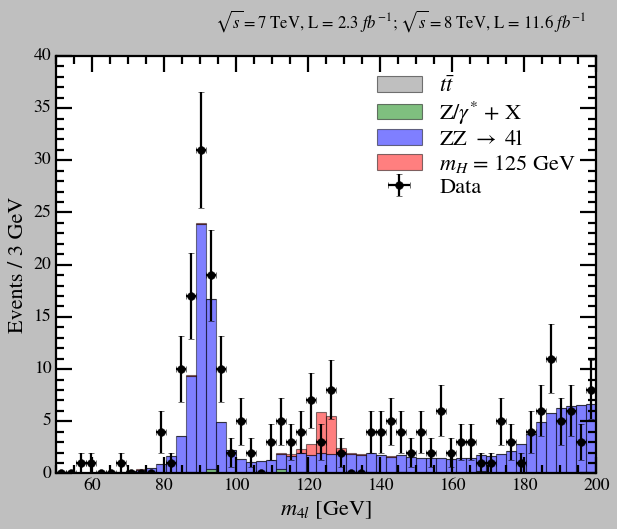

In [411]:
## Now Plot it!!!

plt.figure(figsize = (8,6))
plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data)
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



# Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title('$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$ \n', fontsize = 15, position=(0.64,0.95))
plt.xlabel('$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel('Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(rmin,rmax)
plt.legend(fontsize = 20)

plt.show()

Best fit mu-hat = 1.400
Significance = 4.03 sigma
p-value = 2.831881400031209e-05


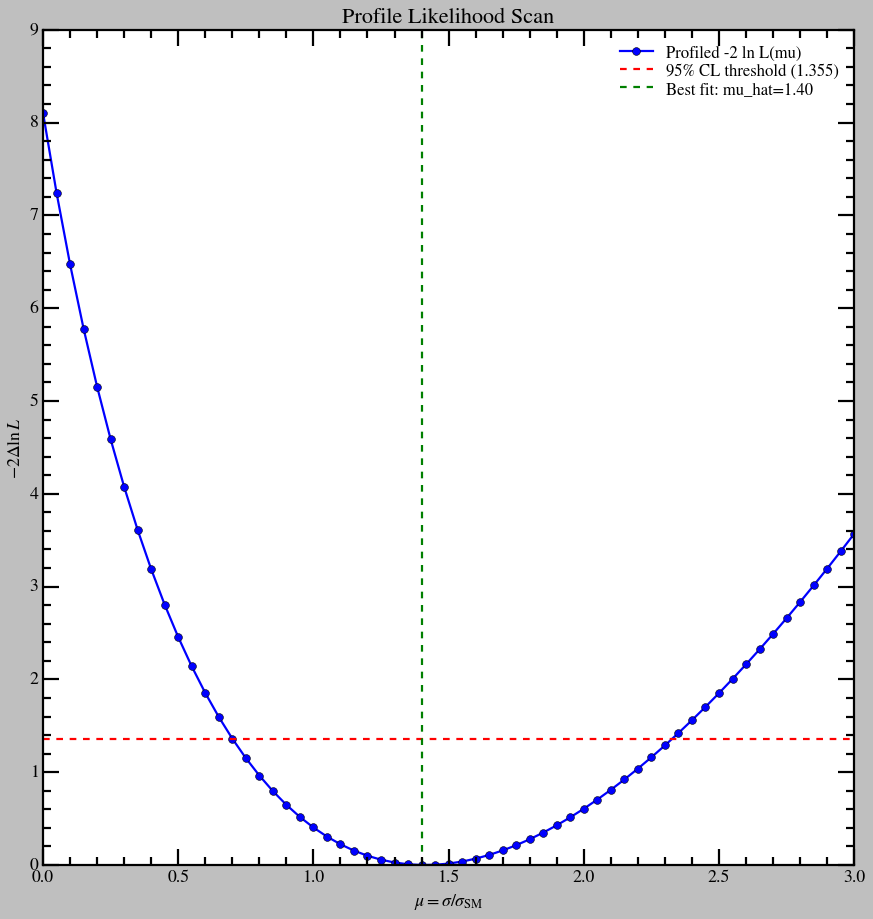

In [403]:
import numpy as np
import matplotlib.pyplot as plt

########################################
# 1) Construct total background vs. signal
########################################
# Suppose you've already computed the following histograms (like in your snippet):
#   hist       = data histogram (array of observed bin counts)
#   hist_higgs = MC Higgs signal histogram (scaled to 1x SM cross section)
#   hist_zz, hist_dy, hist_tt = background components
#
# Then let:
hist_background = hist_zz + hist_dy + hist_tt
hist_signal = hist_higgs

# Make sure all arrays have the same shape
assert len(hist) == len(hist_background) == len(hist_signal), "Histogram length mismatch!"

########################################
# 2) Define a Poisson negative log-likelihood
########################################
def neg_log_likelihood(mu, hist_data, hist_sig, hist_bkg):
    """
    Returns the negative log-likelihood for a single set of (hist_data, hist_sig, hist_bkg)
    under the model: expected[i] = mu * hist_sig[i] + hist_bkg[i].
    
    Assumes Poisson in each bin i:
        L_i = e^-muS_i * (muS_i)^(n_i) / n_i!
    Summed over all bins => total NLL = - sum_i ln(L_i).
    
    - In practice, we skip constant n_i! (it doesn't affect minimization).
    - We also handle bins with zero expected yield carefully (avoid log(0)).
    """
    mu = max(mu, 0.0)  # enforce mu >= 0 for safety
    eps = 1e-12
    nll = 0.0
    for d, s, b in zip(hist_data, hist_sig, hist_bkg):
        expected = mu * s + b
        # Avoid log(0); impose a small floor
        expected = max(expected, eps)
        # Poisson -log L for bin
        # = expected - d * log(expected) + log(d!) [the last term is constant w.r.t mu]
        # We'll omit log(d!) because it's independent of mu
        nll_bin = expected - d * np.log(expected)
        nll += nll_bin
    return nll

########################################
# 3) Profile the likelihood over mu
########################################
def profile_likelihood(hist_data, hist_sig, hist_bkg, mu_values=None):
    """
    Evaluate negative log-likelihood for each mu in mu_values,
    returning arrays (mu_values, nll_values).
    """
    if mu_values is None:
        mu_values = np.linspace(0, 3.0, 61)  # from 0 to 3 in steps of 0.05, as an example
    nll_vals = []
    for mu in mu_values:
        val = neg_log_likelihood(mu, hist_data, hist_sig, hist_bkg)
        nll_vals.append(val)
    return np.array(mu_values), np.array(nll_vals)

# Let's do the likelihood scan
mu_grid = np.linspace(0, 3.0, 61)
mu_scan, nll_scan = profile_likelihood(hist, hist_signal, hist_background, mu_values=mu_grid)

# Find minimum (best-fit mu)
nll_min = np.min(nll_scan)
mu_hat = mu_scan[np.argmin(nll_scan)]
print(f"Best fit mu-hat = {mu_hat:.3f}")

########################################
# 4) Compute significance of signal (vs. background-only)
########################################
# A common measure: significance = sqrt( q_0 ), where
# q_0 = -2 ln[L(mu=0)/L(mu=mu_hat)]  (the test statistic for the background-only vs. best-fit).
#
# For background-only, mu=0:
nll_bkg = neg_log_likelihood(0.0, hist, hist_signal, hist_background)
q_0 = 2.0 * (nll_bkg - nll_min)
if q_0 < 0:
    q_0 = 0  # occasionally can happen due to statistical fluctuations
significance = np.sqrt(q_0)
print(f"Significance = {significance:.2f} sigma")
p_value = norm.sf(significance)  # survival function for one-sided test
print(f"p-value = {p_value}")

########################################
# 5) Estimate the 95% CL upper limit on mu (CLs style)
########################################
# For a simple 1D approach, a common approximation is:
# we find mu_up such that  -2 ln[ L(mu_up)/L(mu_hat) ] = 2.71  (for ~95% 1-sided).
# i.e.   NLL(mu_up) - NLL(mu_hat) = 1.355
########################################

# delta_95 = 1.355  # 2.71 / 2 for the usual "q_mu" definition
# limit_95 = None

# for mu_test, nll_val in zip(mu_scan, nll_scan):
#     if (nll_val - nll_min) < delta_95:
#         # We crossed the threshold
#         limit_95 = mu_test
#         break

# if limit_95 is None:
#     limit_95 = mu_grid[-1]  # If we never crossed, the limit is above our scan range

# print(f"95% CL upper limit on mu = {limit_95:.2f}")

########################################
# 6) (Optionally) Visualize the likelihood scan
########################################
plt.figure()
plt.plot(mu_scan, nll_scan - nll_min, 'bo-', label="Profiled -2 ln L(mu)")
plt.axhline(delta_95, color='r', linestyle='--', label="95% CL threshold (1.355)")
plt.axvline(mu_hat, color='g', linestyle='--', label=f"Best fit: mu_hat={mu_hat:.2f}")
plt.xlabel(r"$\mu = \sigma / \sigma_{\mathrm{SM}}$")
plt.ylabel(r"$-2\Delta \ln L$")
plt.title("Profile Likelihood Scan")
plt.legend()
plt.show()
